### Exploratory Analysis 

In [9]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

OUTPUT_DIR = "../OUTPUTS"          
CITIES = ["New York, NY", "Los Angeles, CA", "Chicago, IL", "San Francisco, CA", "Miami, FL"]

os.makedirs(OUTPUT_DIR, exist_ok=True)
pd.options.display.float_format = "{:,.2f}".format

In [6]:
zhvi_long = pd.read_csv("../DATA/zhvi_clean_long.csv")

# Check structure
zhvi_long.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,date,zhvi
0,394297,677,"Aberdeen, SD",msa,SD,2000-01-31,132475.347593
1,394297,677,"Aberdeen, SD",msa,SD,2000-02-29,132475.347593
2,394297,677,"Aberdeen, SD",msa,SD,2000-03-31,132475.347593
3,394297,677,"Aberdeen, SD",msa,SD,2000-04-30,132475.347593
4,394297,677,"Aberdeen, SD",msa,SD,2000-05-31,132475.347593


In [10]:

def pick_present_cities(zhvi_long: pd.DataFrame, desired: list[str], fallback_n: int = 5) -> list[str]:
    present = set(zhvi_long["RegionName"].unique())
    chosen = [c for c in desired if c in present]
    if chosen:
        return chosen

    # fallback: top by SizeRank among MSAs/cities
    tmp = zhvi_long.copy()
    if "RegionType" in tmp.columns:
        tmp = tmp[tmp["RegionType"].isin(["msa", "metropolitan", "metro", "city"])]
    if "SizeRank" in tmp.columns:
        meta = tmp[["RegionName", "SizeRank"]].drop_duplicates().dropna(subset=["SizeRank"])
        meta = meta.sort_values("SizeRank")
        fallback = meta["RegionName"].head(fallback_n).tolist()
    else:
        fallback = list(tmp["RegionName"].drop_duplicates())[:fallback_n]
    return fallback

cities = pick_present_cities(zhvi_long, CITIES)
print("Comparing metros:", cities)

Comparing metros: ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'San Francisco, CA', 'Miami, FL']


In [17]:

import matplotlib.dates as mdates

def _ensure_list(x):
    """Ensure input is always iterable (for multiple cities)."""
    return x if isinstance(x, (list, tuple, np.ndarray, pd.Series)) else [x]

def _ensure_datetime(s):
    """Convert to datetime if not already."""
    return pd.to_datetime(s, errors="coerce") if not np.issubdtype(s.dtype, np.datetime64) else s

def _format_date_axis(ax):
    """Make date axis readable and consistent across all plots."""
    locator = mdates.AutoDateLocator(minticks=5, maxticks=8)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.figure.autofmt_xdate(rotation=0, ha="center")  # neat, centered labels

# === PLOT 1: ZHVI Level ===
def plot_levels(zhvi_long: pd.DataFrame, regions: list[str], out_path: str | None = None):
    regions = _ensure_list(regions)
    fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
    for r in regions:
        sub = zhvi_long[zhvi_long["RegionName"] == r].copy()
        sub["date"] = _ensure_datetime(sub["date"])
        ax.plot(sub["date"], sub["zhvi"], label=r)
    ax.set_xlabel("Date")
    ax.set_ylabel("ZHVI (USD)")
    ax.set_title("Major Metros — ZHVI (Level)")
    ax.legend()
    ax.grid(True, alpha=0.2)
    _format_date_axis(ax)
    fig.tight_layout()
    if out_path:
        fig.savefig(out_path, dpi=160)
        print(f"Saved: {out_path}")
    plt.show()

# === PLOT 2: Indexed Growth (normalized at common start) ===
def plot_indexed(zhvi_long: pd.DataFrame, regions: list[str], out_path: str | None = None):
    regions = _ensure_list(regions)
    zhvi_long["date"] = _ensure_datetime(zhvi_long["date"])
    common_start = max(zhvi_long[zhvi_long["RegionName"] == r]["date"].min() for r in regions)
    fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
    for r in regions:
        sub = zhvi_long[(zhvi_long["RegionName"] == r) & (zhvi_long["date"] >= common_start)].copy()
        if not sub.empty:
            base = sub.iloc[0]["zhvi"]
            sub["index"] = sub["zhvi"] / base * 100.0
            ax.plot(sub["date"], sub["index"], label=r)
    ax.set_xlabel("Date")
    ax.set_ylabel("Index (first common month = 100)")
    ax.set_title("Major Metros — ZHVI Indexed Growth")
    ax.legend()
    ax.grid(True, alpha=0.2)
    _format_date_axis(ax)
    fig.tight_layout()
    if out_path:
        fig.savefig(out_path, dpi=160)
        print(f"Saved: {out_path}")
    plt.show()

# === PLOT 3: Year-over-Year Percentage Change ===
def plot_yoy_pct(zhvi_long: pd.DataFrame, regions: list[str], out_path: str | None = None):
    regions = _ensure_list(regions)
    zhvi_long["date"] = _ensure_datetime(zhvi_long["date"])
    fig, ax = plt.subplots(figsize=(10, 5), dpi=120)
    for r in regions:
        sub = zhvi_long[zhvi_long["RegionName"] == r].set_index("date").sort_index().copy()
        sub["yoy_pct"] = sub["zhvi"].pct_change(12) * 100.0
        ax.plot(sub.index, sub["yoy_pct"], label=r)
    ax.set_xlabel("Date")
    ax.set_ylabel("YoY Change (%)")
    ax.set_title("Major Metros — ZHVI YoY % Change")
    ax.legend()
    ax.grid(True, alpha=0.2)
    _format_date_axis(ax)
    fig.tight_layout()
    if out_path:
        fig.savefig(out_path, dpi=160)
        print(f"Saved: {out_path}")
    plt.show()


Saved: ../OUTPUTS/eda_multicity_levels.png


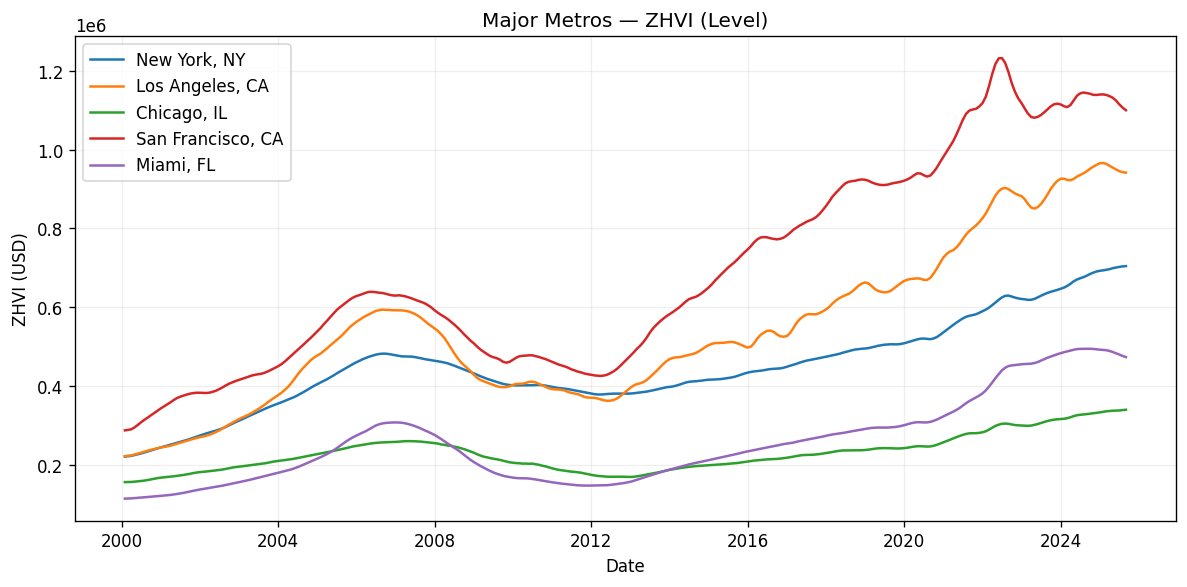

Saved: ../OUTPUTS/eda_multicity_indexed.png


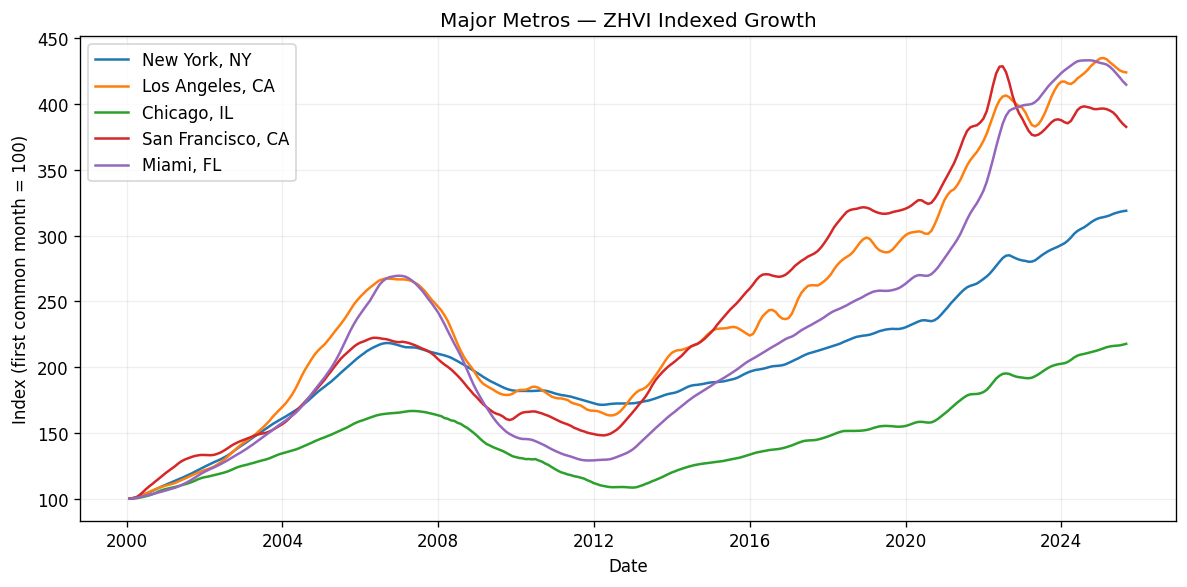

Saved: ../OUTPUTS/eda_multicity_yoy.png


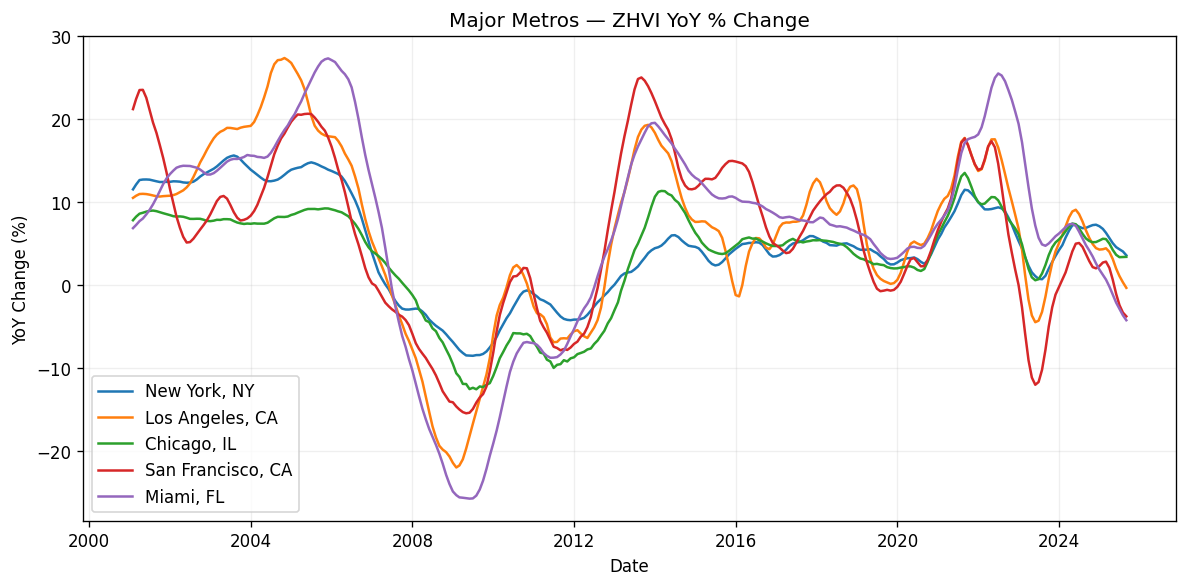

In [18]:

p1 = os.path.join(OUTPUT_DIR, "eda_multicity_levels.png")
p2 = os.path.join(OUTPUT_DIR, "eda_multicity_indexed.png")
p3 = os.path.join(OUTPUT_DIR, "eda_multicity_yoy.png")

plot_levels(zhvi_long, cities, p1)
plot_indexed(zhvi_long, cities, p2)
plot_yoy_pct(zhvi_long, cities, p3)


In [14]:

summary = (
    zhvi_long[zhvi_long["RegionName"].isin(cities)]
    .groupby("RegionName")
    .agg(
        first_date=("date", "min"),
        last_date=("date", "max"),
        obs=("zhvi", "size"),
        first_value=("zhvi", "first"),
        last_value=("zhvi", "last"),
        median=("zhvi", "median"),
    )
)
summary["total_growth_%"] = (summary["last_value"] / summary["first_value"] - 1) * 100
summary


,first_date,last_date,obs,first_value,last_value,median,total_growth_%
RegionName,,,,,,,
"Chicago, IL",2000-01-31,2025-08-31,308,"156,057.93","339,815.52","222,986.64",117.75
"Los Angeles, CA",2000-01-31,2025-08-31,308,"222,015.51","941,801.26","509,603.01",324.21
"Miami, FL",2000-01-31,2025-08-31,308,"114,109.34","473,386.69","236,142.87",314.85
"New York, NY",2000-01-31,2025-08-31,308,"220,834.76","704,429.49","436,967.18",218.98
"San Francisco, CA",2000-01-31,2025-08-31,308,"287,427.17","1,100,173.64","619,865.98",282.77
